**Daniel Yu**

Spring 2024

CS 252: Mathematical Data Analysis and Visualization

# Project 5: Singular Value Decomposition and Recommender Systems

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 14})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

C:\Users\danny\AppData\Local\Temp\ipykernel_2368\2312247994.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Task 2: Preprocessing the MovieLens dataset

We will use SVD to recommend movies to users based on their and other people's ratings. Like your favorite streaming service (Netflix, Prime, Hulu, etc.) you will suggest movies that a user has not seen but is most likely to enjoy watching!

We will work with the [MovieLens dataset](https://grouplens.org/datasets/movielens/), which is composed of ~62,500 "star" ratings of movies. *Download and use the CSV files on the project website, which have been preprocessed to make your life easier.*

#### Notes about MovieLens variables
- `userId`: int label for a user. For example, a `userId` of `80` means "user 80". The ints are numbered `0, ..., num_users-1`. Each user has a unique label and the labels are consistent across fit and test sets (i.e. if a `userId` of `80` appears in both the fit and test sets, it is the same user in both cases).
- `movieId`: int label for a movie. For example, a `movieId` of `7` means "movie 7". The ints are numbered `0, ..., num_movies-1`. Each movie has a unique label and the labels are consistent across fit and test sets (i.e. if a `movieId` of `7` appears in both the fit and test sets, it is the same movie in both cases).
- `rating`: float representing a star rating on a scale of `0.5` stars (worst rating) to `5.0`  stars (best rating) in 0.5 star increments (i.e. possible ratings: `[0.5, 1.0, ..., 5.0]`).
- `timestamp`: int corresponding to when the movie was reviewed by the user. Larger values indicate later times.
- `title`: The string title of the movie rated (e.g. `Titanic (1997)`).
- `genres`: String containing the movie genres. Multiple genres for a movie are delimited by a `|` character (e.g. `Drama|Romance` means the movie has two genres — Drama and Romance).

### 2a. Load in the MovieLens dataset

In the cell below, load in the MovieLens dataset as a Pandas DataFrame (`movielens.csv`). Show the 1st five rows of the MovieLens DataFrame.

In [2]:
df = pd.read_csv('data/movielens.csv')
print(df.head(5))

   userId  movieId  rating  timestamp                        title  \
0       0        0     4.0  964982703             Toy Story (1995)   
1       0        2     4.0  964981247      Grumpier Old Men (1995)   
2       0        4     4.0  964982224                  Heat (1995)   
3       0       23     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       0       25     5.0  964982931   Usual Suspects; The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


### 2b. Determine the number of users and movies in the dataset

Currently, the data are organized as one long table where each sample (row) is only ONE specific rating. If a user rates multiple movies, they appear on separate lines. To run SVD, we will want to create a matrix where
- rows: users (user 0, user 1, user 2, ...).
- columns: movies (movie 0, movie 1, ...).

Before you can create this matrix, determine `N` (number of *unique* users) and `M` (number of *unique* movies) in the cell below.

Your should not hard code the number of users and movies (i.e. your code should work if the specific dataset were swapped out).

**Hint:** Search the NumPy documentation for the italicized word above.

In [3]:
num_users = np.unique(df['userId']).shape[0]
num_movies = np.unique(df['movieId']).shape[0]
print(f'Dataset has {num_users=} and {num_movies=}')

Dataset has num_users=610 and num_movies=1050


### 2c. Build the user-item matrix

This is the "A data matrix" that will serve as the input to SVD.

1. Write the `user_item_matrix` function below that takes a pandas DataFrame and builds the **user-item matrix** that has shape `(N, M)`.
2. Call your `user_item_matrix` function to make the user-item matrix.

**Note:** "Item" here means "movie". 

In [4]:
def user_item_matrix(df, num_users, num_movies):
    '''Converts data where each sample is a single user rating to a user-item matrix

    Parameters:
    -----------
    df: pandas DataFrame. Each sample corresponds to the one user (`userId`) rating (`rating`) one movie (`movieId`).
    num_users: int. Number of unique users in the dataset (N).
    num_movies: int. Number of unique movies in the dataset (M).

    Returns:
    -----------
    user-item matrix ("A" matrix). ndarray. shape=(N, M). Matrix where rows correspond to users, columns correspond to
        movies. Unrated movies are represented with a 0 rating (the minimum actual rating given by users is 0.5).

    NOTE: It may be help to convert the columns of the DataFrame that you extract to NumPy ndarrays.
    '''
    pass
    user_item_matrix = np.zeros((num_users, num_movies))
    for index, row in df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])
        rating = row['rating']
        
        user_item_matrix[user_id, movie_id] = rating
    
    return user_item_matrix

# Make the actual user-item matrix here
A = user_item_matrix(df, num_users, num_movies)


print(f'The shape of your user-item matrix is {A.shape=} and it should be (610, 1050).')
print(f'The user-item matrix is a ndarray as it should be? {isinstance(A, np.ndarray)}.')
print(f'The sum of ALL ratings is {A.sum()} and it should be 227818.5.')

The shape of your user-item matrix is A.shape=(610, 1050) and it should be (610, 1050).
The user-item matrix is a ndarray as it should be? True.
The sum of ALL ratings is 227818.5 and it should be 227818.5.


### 2d. Create fit and validation sets

This subtask involves setting aside an array of nonzero user ratings for validation so that you will be able to later assess the accuracy of the predicted ratings on rating not used to fit your recommender system. In the cell below:

1. Load in `movielens_val_indices.csv` as a DataFrame and print out a preview. Each row is the `(row, col)` index of a rating in `A` that should be entered into the validation set. (*total number of rows = number of validation samples*).
2. Extract ratings from `A` at these rows and cols and assign them to a 1D ndarray called `val_ratings`.
3. Make the fit set (`A_fit`): A **copy** of `A` except that you should set the ratings at the validation set `(rows, cols)` to "unrated" (set to 0).

In [5]:
#1
val_indices_df = pd.read_csv('data/movielens_val_indices.csv')
print(val_indices_df.head())
#2
val_ratings = A[val_indices_df['row_inds'], val_indices_df['col_inds']]
#3
A_fit = np.copy(A)
A_fit[val_indices_df['row_inds'].values, val_indices_df['col_inds'].values] = 0

   row_inds  col_inds
0       541       743
1       306       387
2       153       958
3       554       649
4       253       719


In [6]:
print(f'Your validation set ratings has shape {val_ratings.shape} and it should be (6252,).')
print(f'The first three validation set ratings are {val_ratings[:3]} and they should be [4. 2. 5.].')
print(f'The last three validation set ratings are {val_ratings[-3:]} and they should be [3. 3. 4.].')
print(f'The sum of all ratings in the original A matrix is {A.sum()} and it should be 227818.5.')
print(f'The sum of all ratings in the fit set A matrix is {A_fit.sum()} and it should be 205049.0.')

Your validation set ratings has shape (6252,) and it should be (6252,).
The first three validation set ratings are [4. 2. 5.] and they should be [4. 2. 5.].
The last three validation set ratings are [3. 3. 4.] and they should be [3. 3. 4.].
The sum of all ratings in the original A matrix is 227818.5 and it should be 227818.5.
The sum of all ratings in the fit set A matrix is 205049.0 and it should be 205049.0.


## Task 3: Recommender Model 1 (Mean user rating)

Your goal is to implement and compare the accuracy of 3 different recommender systems. The first and simplest is the **mean user rating model**: To predict how a user would rate a movie:
- return the user's movie rating if the user already rated that movie. *For example, if user 5 has rated Titanic a 4.5, then the model return 4.5 if predicting user 5's rating for Titanic.*
- return the mean of ratings that the user has provided if the user has not rated the queried movie. *For example, if user 2 has not rated Titanic but they have rated 9 movies and across those 9 movies the average rating is 3.2. Then the model returns 3.2.*

### 3a. Implement `Recommender` and `Mean` recommender classes

I suggest working in the following order, but feel free to work in any order that you like!

In `rec_sys.py` implement and test the following methods in the `Recommender` class and the `Mean` class that inherits from `Recommender`.
- constructor (Recommender)
- `replace_missing_with_mean` (Recommender)
- `fit` (Mean)
- `predict` (Mean)
- `predict_user_item_ratings` (Recommender)
- `rmse` (Recommender)

In [7]:
from rec_sys import Recommender, Mean

#### (i) Test `replace_missing_with_mean`

In [8]:
test_rec = Recommender(1)
test_A = np.array([[1, 3, 0, 7, 9], [0, 0, 1, 0, 9], [2, 2, 2, 0, 2], [2, 0, 3, 3, 2]], dtype=float)
test_rep_A = test_rec.replace_missing_with_mean(test_A)
print('Your user-item matrix with filled in values for missing ratings are')
print(test_rep_A)
print('and should be:')
print('''[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]''')

Your user-item matrix with filled in values for missing ratings are
[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]
and should be:
[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]


#### (ii) Test `fit` and `predict`

In [9]:
test_rec = Mean()
test_A = np.array([[1, 3, 0, 7, 9], [0, 0, 1, 0, 9], [2, 2, 2, 0, 2], [2, 0, 3, 3, 2]], dtype=float)
test_rec.fit(test_A)
print('Your predicted user-item matrix is')
print(test_rec.predict())
print('and should be:')
print('''[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]''')
print('The original test matrix is')
print(test_A)
print('and should be:')
print('''[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]''')

Your predicted user-item matrix is
[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]
and should be:
[[1.  3.  5.  7.  9. ]
 [5.  5.  1.  5.  9. ]
 [2.  2.  2.  2.  2. ]
 [2.  2.5 3.  3.  2. ]]
The original test matrix is
[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]
and should be:
[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]


#### (iii) Test `predict_user_item_ratings`

In [10]:
test_rec = Mean()
test_A = np.array([[1, 3, 0, 7, 9], [0, 0, 1, 0, 9], [2, 2, 2, 0, 2], [2, 0, 3, 3, 2]], dtype=float)
test_rec.fit(test_A)
test_users = np.array([0, 0, 1, 2, 2, 2, 3])
test_movies = np.array([2, 3, 1, 0, 2, 3, 1])
test_preds = test_rec.predict_user_item_ratings(test_users, test_movies)
print(f'The predicted ratings are\n{test_preds} and should be\n[5.  5.  5.  2.  2.  2.  2.5]')

The predicted ratings are
[5.  5.  5.  2.  2.  2.  2.5] and should be
[5.  5.  5.  2.  2.  2.  2.5]


#### (iv) Test `rmse`

In [11]:
test_rec = Recommender(1)
test_rat1 = np.array([1, 3, 0, 7, 9, 0, 0, 1, 0, 9], dtype=float)
test_rat2 = np.array([2, 1, 5, 5, 5, 2, 1, 3, 5, 1], dtype=float)
test_err = test_rec.rmse(test_rat1, test_rat2)
print(f'The RMSE is {test_err:.4f} and should be 3.8471')

The RMSE is 3.8471 and should be 3.8471


### 3b. Evaluate the predicted ratings produced by the mean user rating model

In the cell below:
1. Fit the Mean user rating model to fit set.
2. Print out the **validation set RMSE** in the cell below.

**Reminders:**
- `predict_user_item_ratings` takes in 1D ndarrays of validation user and movie IDs (i.e. `rows` and `cols` of the validation set ratings, respectively). It does NOT take in user-item matrices (i.e. "A" matrices).
- `rmse` takes in 1D ndarrays of ratings, not user-item matrices (i.e. "A" matrices).

In [12]:
mean_recommender = Mean()
mean_recommender.fit(A_fit)
val_predicted_ratings = mean_recommender.predict_user_item_ratings(val_indices_df['row_inds'], val_indices_df['col_inds'])
val_actual_ratings = val_ratings
val_rmse = mean_recommender.rmse(val_actual_ratings, val_predicted_ratings)
print(f'Validation set RMSE for Mean user rating model: {val_rmse}')

Validation set RMSE for Mean user rating model: 0.9179172852260945


## Task 4: Recommender Model 2 (SVD)

This model involves computing the Truncated SVD of the fit set user-item matrix with `k` basis vectors. It uses prevalent factors/patterns to "fill in" ratings for unrated movies.

### 4a. Implement the `SVD` class 

In `rec_sys.py` implement and test the following methods in the `SVD` class:
- constructor
- `fit`
- `predict`

In [13]:
from rec_sys import SVD

#### Test `fit` and `predict`

In [14]:
test_rec = SVD(2)
test_A = np.array([[1, 3, 0, 7, 9], [0, 0, 1, 0, 9], [2, 2, 2, 0, 2], [2, 0, 3, 3, 2]], dtype=float)
test_rec.fit(test_A)
print('Your predicted user-item matrix is')
print(test_rec.predict())
print('and should be:')
print('''[[1.03451 3.04992 5.03657 7.03944 8.95974]
 [4.98082 4.97226 0.97968 4.97809 9.02237]
 [2.20489 2.29635 2.21707 2.23415 1.76097]
 [1.77977 2.18146 2.76668 2.74832 2.25692]]''')
test_users = np.array([0, 0, 1, 2, 2, 2, 3])
test_movies = np.array([2, 3, 1, 0, 2, 3, 1])
test_preds = test_rec.predict_user_item_ratings(test_users, test_movies)
print(f'The predicted ratings are\n{test_preds} and should be\n[5.      5.      4.97226 2.20489 2.21707 2.23415 2.18146]')
print('The original test matrix is')
print(test_A)
print('and should be:')
print('''[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]''')

Your predicted user-item matrix is
[[1.03451 3.04992 5.03657 7.03944 8.95974]
 [4.98082 4.97226 0.97968 4.97809 9.02237]
 [2.20489 2.29635 2.21707 2.23415 1.76097]
 [1.77977 2.18146 2.76668 2.74832 2.25692]]
and should be:
[[1.03451 3.04992 5.03657 7.03944 8.95974]
 [4.98082 4.97226 0.97968 4.97809 9.02237]
 [2.20489 2.29635 2.21707 2.23415 1.76097]
 [1.77977 2.18146 2.76668 2.74832 2.25692]]
The predicted ratings are
[5.      5.      4.97226 2.20489 2.21707 2.23415 2.18146] and should be
[5.      5.      4.97226 2.20489 2.21707 2.23415 2.18146]
The original test matrix is
[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]
and should be:
[[1. 3. 0. 7. 9.]
 [0. 0. 1. 0. 9.]
 [2. 2. 2. 0. 2.]
 [2. 0. 3. 3. 2.]]


### 4b. Determine the optimal number of basis vectors for SVD recommender model

In the cell below:
1. Repeatedly fit your SVD recommender model to the fit set with different numbers of basis vectors. Each time compute and **record the RMSE on the validation set**.
2. Create a "high quality" well-labeled plot showing the RMSE for each number of basis vectors that you try out.

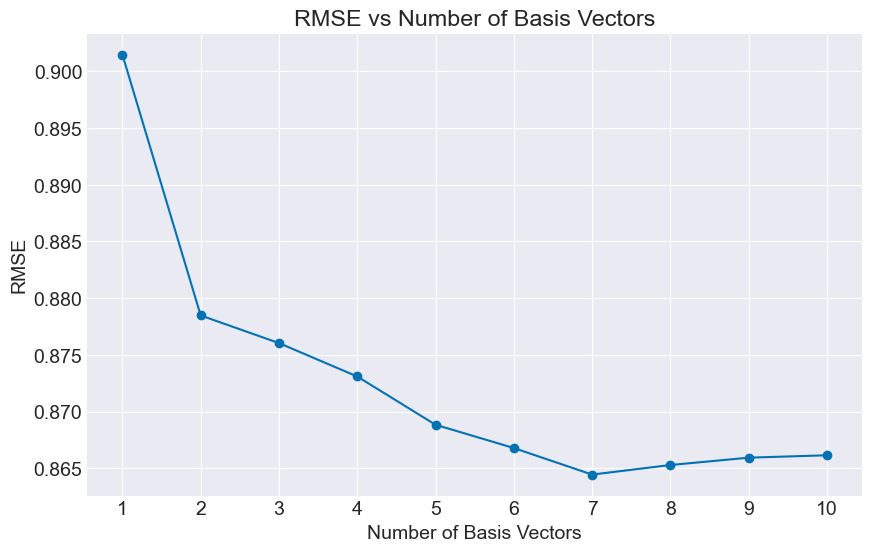

In [15]:
num_basis_vectors_list = [1,2,3,4,5,6,7,8,9,10]
rmse_values = []

for num_bvs in num_basis_vectors_list:
    svd_model = SVD(num_bvs)
    svd_model.fit(A_fit)
    val_preds = svd_model.predict()
    val_preds_extracted = val_preds[val_indices_df['row_inds'], val_indices_df['col_inds']]
    rmse_val = svd_model.rmse(val_ratings, val_preds_extracted)
    rmse_values.append(rmse_val)

plt.figure(figsize=(10, 6))
plt.plot(num_basis_vectors_list, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs Number of Basis Vectors')
plt.xlabel('Number of Basis Vectors')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(num_basis_vectors_list)
plt.show()

### 4c. Questions

**Question 4:** Based on your analysis, how many basis vectors should you select to get the best generalization accuracy?

**Answer 4:** Looks like 7, since it's the only dip in the mean squared error, and from that point it only goes higher from there. That's when the error is the lowest of between fit and validation sets.

## Task 5: Recommender Model 3 (Funk SVD)

Funk SVD, based on SVD and introduced by Simon Funk, reached 3rd place (but did not finish 3rd) on the [Netflix](https://en.wikipedia.org/wiki/Netflix_Prize) [prize](https://sifter.org/~simon/journal/20061211.html).

### 5a. Implement Funk SVD

In `rec_sys.py` implement and test the following methods in the `FunkSVD`:
- constructor
- `get_user_factor_matrix`
- `get_factor_item_matrix`
- `fit`
- `predict`

#### Funk SVD matrix decomposition

With the Funk SVD algorithm, we are attempting to write the user-item matrix $A$ as the product of two other matrices:

$$A \approx UI$$

where $U$ is called the **user-factor** matrix (`shape=(N, K)`), $I$ is called the **factor-item** matrix (`shape=(K, M)`), and $K$ denotes the number of basis vectors (or **factors**) that we are using. That is, we are trying to express the matrix $A$ as the product of two other matrices with appropriate shapes.

#### Funk SVD update equations

In Funk SVD, we initialize $U$ and $I$ with random values and progressively determining better values for each entry based on the error in approximating the original matrix $A$ through an optimization approach called **gradient descent**. The idea is that we initially do a poor job at approximating $A$ and make small tweaks to $U$ and $I$ over many iterations until we ultimately do a good job. 

Unlike regular SVD, Funk SVD makes tweaks to single entries in $U$ and $I$ based on where in $A$ we have actual ratings (i.e. non-zero values). For every actual non-zero rating in $A$ at index `i` and `j`, we make an update to both **a row of** $U$ and **a col of** $I$ so that the dot product of this row and col will multiply out to more closely equal the entry in $A$ at index `(i, j)`.

Here are the equations that summarize the change ($dU$ and $dI$) to single entries in $U$ and $I$, respectively, on every iteration of Funk SVD:

$$
dU_{ik} =  -(e I_{kj} - \alpha U_{ik})
$$
$$
dI_{kj} = -(e U_{ik} - \alpha I_{kj})
$$

where $e$ is a float representing the difference between the actual non-zero rating in $A$ at index `(i, j)` and the dot product between row `i` of $U$ and col `j` of $I$. The parameter $\alpha$ is the regularization strength. Then the actual entry in $U$ and $I$ get updated via the update step equation of form $$Blah = Blah - \eta* dBlah$$ where $\eta$ is the step size.

In [16]:
from rec_sys import FunkSVD

#### Test one iteration of `fit` and `predict`

In [45]:
test_rec = FunkSVD(3)
test_A = np.array([[1, 3, 0, 7, 9], [0, 0, 1, 0, 9], [2, 2, 2, 0, 2], [2, 0, 3, 3, 2]], dtype=float)
np.random.seed(0)
test_rec.fit(test_A, step=0.1, n_iter=1, reg=0.5)
print('After 1 iteration of Funk SVD fit, your U matrix looks like')
print(test_rec.get_user_factor_matrix())
print('and it should look like:')
print('''[[0.63286 1.84249 1.05813]
 [0.88374 1.72323 1.26302]
 [0.28009 0.59272 0.64859]
 [0.34602 0.8294  0.49223]]''')
print('\nAfter 1 iteration of Funk SVD fit, your I matrix looks like')
print(test_rec.get_factor_item_matrix())
print('and it should look like:')
print('''[[0.54052 0.91272 0.21688 0.46429 0.704  ]
 [0.83058 0.80366 1.02611 1.38696 1.59438]
 [0.49471 0.79101 0.3385  0.99201 1.0269 ]]''')

After 1 iteration of Funk SVD fit, your U matrix looks like
[[0.63286 1.84249 1.05813]
 [0.88374 1.72323 1.26302]
 [0.28009 0.59272 0.64859]
 [0.34602 0.8294  0.49223]]
and it should look like:
[[0.63286 1.84249 1.05813]
 [0.88374 1.72323 1.26302]
 [0.28009 0.59272 0.64859]
 [0.34602 0.8294  0.49223]]

After 1 iteration of Funk SVD fit, your I matrix looks like
[[0.54052 0.91272 0.21688 0.46429 0.704  ]
 [0.83058 0.80366 1.02611 1.38696 1.59438]
 [0.49471 0.79101 0.3385  0.99201 1.0269 ]]
and it should look like:
[[0.54052 0.91272 0.21688 0.46429 0.704  ]
 [0.83058 0.80366 1.02611 1.38696 1.59438]
 [0.49471 0.79101 0.3385  0.99201 1.0269 ]]


In [46]:
print('After 1 iteration of Funk SVD fit, your predicted A matrix is')
print(test_rec.predict())
print('and it should be')
print('''[[2.39587 2.89535 2.38603 3.89896 4.46976]
 [2.53379 3.19057 2.38743 4.05328 4.66663]
 [0.96456 1.24503 0.88849 1.59552 1.80824]
 [1.11942 1.37173 1.09272 1.79928 2.07144]]''')

After 1 iteration of Funk SVD fit, your predicted A matrix is
[[2.39587 2.89535 2.38603 3.89896 4.46976]
 [2.53379 3.19057 2.38743 4.05328 4.66663]
 [0.96456 1.24503 0.88849 1.59552 1.80824]
 [1.11942 1.37173 1.09272 1.79928 2.07144]]
and it should be
[[2.39587 2.89535 2.38603 3.89896 4.46976]
 [2.53379 3.19057 2.38743 4.05328 4.66663]
 [0.96456 1.24503 0.88849 1.59552 1.80824]
 [1.11942 1.37173 1.09272 1.79928 2.07144]]


### 5b. Compare the test accuracy of mean user rating, SVD, and Funk SVD recommender systems

In the cell below fit each of the three recommender system models on the MovieLens fit set and evaluate the RMSE error on the validation set.

When setting up your recommender system fits
- use the optimal number of basis vectors when fitting the SVD model that you determined in your analysis above.
- Use `4` basis vectors for Funk SVD and the defaults for the other parameters.


Create a "high quality" [horizontal side bar chart](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html) that summarizes the accuracy of all three models.
- Make the y values correspond to the 3 models and the x values should the corresponding RMSE value on the test set.
- Either annotate your bars with the numeric RMSE values or print them out.

**NOTE:** It should take a few minutes for Funk SVD to run. Something may be wrong if the runtime exceeds 5 minutes, even on slower computers.

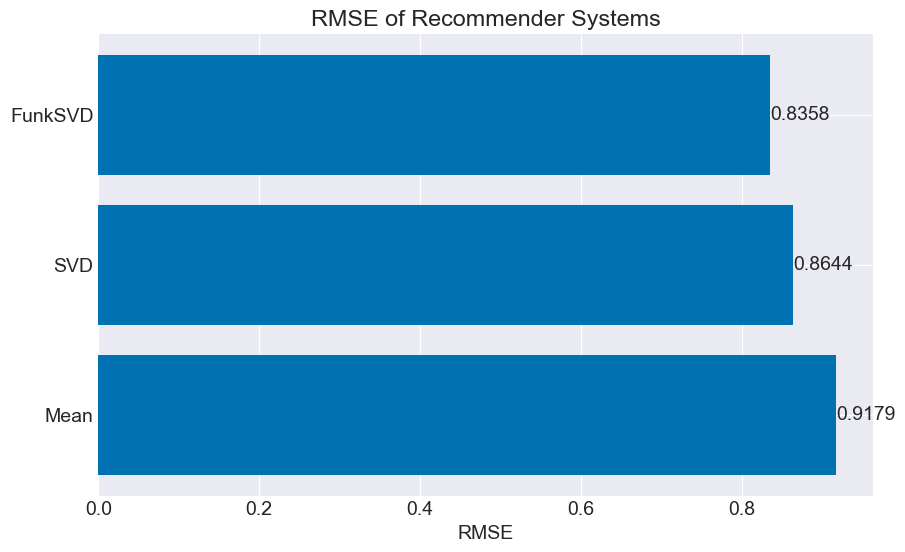

In [19]:
np.random.seed(0)
val_user_indices = val_indices_df['row_inds']
val_movie_indices = val_indices_df['col_inds']
rmse_values = []

mean_model = Mean()
mean_model.fit(A_fit)
pred_ratings = mean_model.predict_user_item_ratings(val_user_indices, val_movie_indices)
rmse_mean = mean_model.rmse(val_ratings, pred_ratings)
rmse_values.append(rmse_mean)

svd_model = SVD(7)  
svd_model.fit(A_fit)
pred_ratings = svd_model.predict_user_item_ratings(val_user_indices, val_movie_indices)
rmse_svd = svd_model.rmse(val_ratings, pred_ratings)
rmse_values.append(rmse_svd)

funk_model = FunkSVD(4)
funk_model.fit(A_fit)
pred_ratings = funk_model.predict_user_item_ratings(val_user_indices, val_movie_indices)
rmse_funk = funk_model.rmse(val_ratings, pred_ratings)
rmse_values.append(rmse_funk)

models = ['Mean', 'SVD', 'FunkSVD']
plt.figure(figsize=(10, 6))
plt.barh(models, rmse_values)
plt.xlabel('RMSE')
plt.title('RMSE of Recommender Systems')
for index, value in enumerate(rmse_values):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center')
plt.show()

### 5c. Questions

**Question 5:** Which model does the best, which does the worst and why?

**Answer 5:** Looks like the FunkSVD does the best with the lowest MSE, in exchange for runtime its more precise by iterating through the rows and columns until it ultimately gets a better answer. On the other hand, the Mean model does the worst, which is to be expected because it simply replaces missing ratings with the mean rating of each user. While it's simple and easy to compute, it doesn't capture any underlying patterns or preferences of users and movies. As a result, its predictive power is limited.

## Task 6: Recommend movies to users

Now that you have built recommender systems that predict how users will rate a movie, let's do what streaming services do — recommend which movies a specific user will like most that they have not seen!

### 6a. Determine a user's top rated movies

To make this more meaningful, first write and test the function `get_top_rated_movies` to determine a list of the movie title strings of the top rated movies that a specific user HAS already seen (i.e. **has rated**). Remember, these are a user's nonzero rating values.

**Note:**
- `movie_map` is a Python dictionary that maps the movieID int (key) to the corresponding string name (value). See test code and docstring for an example.
- **You should essentially just need to copy-paste your code (and rename) from lab for this part!**

In [20]:
def get_top_rated_movies(A, movie_map, user_id, num_top_rated):
    '''Determines the `num_top_rated` movies that `user_id` rated most highly.

    Parameters:
    -----------
    A: ndarray. shape=(N, M). User-item matrix of star ratings ranging from 0. to 5.
            0 means movie is unrated by a user.
    movie_map: dictionary. keys=movieId (int), values=movie title (str).
    user_id: int. The ID of the user whose top rated movies we would like to determine.
    num_top_rated: int. Number of top rated movies that should be determined.

    Returns:
    -----------
    list. len=num_top_rated. String names of user `user_id`'s top rated movies.
        Format: [User's most highly rated movie, User's 2nd most highly rated movie, ...]
    '''
    pass
    user_ratings = A[user_id, :]
    rated_indices = user_ratings.nonzero()[0]
    rated_ratings = user_ratings[rated_indices]
    top_ratings = np.flip(np.argsort(rated_ratings))[:num_top_rated]
    sorted_movie_indices = rated_indices[top_ratings]
    top_rated_movies = [movie_map[movie_id] for movie_id in sorted_movie_indices[:num_top_rated]]
    return top_rated_movies

#### Test `get_top_rated_movies`

In [21]:
np.random.seed(0)
test_A = np.random.randint(low=0, high=6, size=(3, 7))
test_movie_map = {0: 'The Shawshank Redemption',
                  1: 'The Godfather',
                  2: 'Pulp Fiction',
                  3: 'The Dark Knight',
                  4: 'Titanic',
                  5: 'Inception',
                  6: 'Jurassic Park'}
top_rated = [['The Godfather', 'The Shawshank Redemption', 'Inception', 'Titanic'],
             ['The Godfather', 'Jurassic Park', 'The Dark Knight', 'The Shawshank Redemption'],
             ['Jurassic Park', 'Titanic', 'The Shawshank Redemption', 'Inception']]
for i in range(len(test_A)):
    print(75*'-')
    print(f'Test {i+1}/3')
    print(f'User {i}s movie ratings are:')
    print(test_A[i])
    print(f'User {i}s top 4 rated movies are:')
    print(get_top_rated_movies(test_A, test_movie_map, user_id=i, num_top_rated=4))
    print('and should be:')
    print(top_rated[i])

---------------------------------------------------------------------------
Test 1/3
User 0s movie ratings are:
[4 5 0 3 3 3 1]
User 0s top 4 rated movies are:
['The Godfather', 'The Shawshank Redemption', 'Inception', 'Titanic']
and should be:
['The Godfather', 'The Shawshank Redemption', 'Inception', 'Titanic']
---------------------------------------------------------------------------
Test 2/3
User 1s movie ratings are:
[3 5 2 4 0 0 4]
User 1s top 4 rated movies are:
['The Godfather', 'Jurassic Park', 'The Dark Knight', 'The Shawshank Redemption']
and should be:
['The Godfather', 'Jurassic Park', 'The Dark Knight', 'The Shawshank Redemption']
---------------------------------------------------------------------------
Test 3/3
User 2s movie ratings are:
[2 1 0 1 5 1 5]
User 2s top 4 rated movies are:
['Jurassic Park', 'Titanic', 'The Shawshank Redemption', 'Inception']
and should be:
['Jurassic Park', 'Titanic', 'The Shawshank Redemption', 'Inception']


### 6b. Determine top recommendations of movies a user has not seen

Write `get_top_recommendations` below to produce top movie recommendations for a specific user `user_id` from the user-item matrix $A$ and fitted recommendation system `rec_model`.

**Note:**
- The test code below uses your SVD recommender model.
- **You should essentially just need to copy-paste your code (and rename) from lab for this part!**

In [22]:
def get_top_recommendations(A, rec_model, movie_map, user_id, num_top_recommendations):
    '''Determines the `num_top_recommendations` movie recommendations among the movies that user `user_id` has NOT rated.

    Parameters:
    -----------
    A: ndarray. shape=(N, M). User-item matrix of star ratings ranging from 0. to 5.
            0 means movie is unrated by a user.
    rec_model: Recommender. One of your fitted recommender systems.
    movie_map: dictionary. keys=movieId (int), values=movie title (str).
    user_id: int. The ID of the user for which we would like to recommend movies.
    num_top_recommendations: int. Number of top movie recommendations we would like to make.

    Returns:
    -----------
    list. len=num_top_recommendations. String names of top recommended movies for user `user_id`.
        Format: [Top recommendation for user, 2nd best recommendation for user, ...]

    NOTE:
    - `predict_user_item_ratings` expects an ndarray of INTS. It may not be pleased with a float dtype.
    - You will need to handle the fact that `predict_user_item_ratings` expects that array `test_userids` that is the same
    length as the `test_movieids` array, even if all the queries for predicted rating come from a single user, which is
    the case here.
    - There should be significant overall with how you implemented the `get_top_rated_movies` function.
    '''
    pass
    user_ratings = A[user_id, :]
    unrated_movies = np.where(user_ratings == 0)[0]
    test_userids = np.full(len(unrated_movies), user_id, dtype=int)
    test_movieids = unrated_movies
    predicted_ratings = rec_model.predict_user_item_ratings(test_userids, test_movieids)
    # print(predicted_ratings)
    sorted_movie_indices = unrated_movies[np.argsort(predicted_ratings)][::-1]
    top_recommendations = [movie_map[movie_id] for movie_id in sorted_movie_indices[:num_top_recommendations]]
    return top_recommendations

#### Test `get_top_recommendations`

In [23]:
np.random.seed(0)
test_A = np.array([[0, 1, 2, 3, 4, 4.5, 5],
                   [0, 0, 0, 5, 0, 1, 4],
                   [3, 2, 1, 5, 4, 1, 3]])
test_movie_map = {0: 'The Shawshank Redemption',
                  1: 'The Godfather',
                  2: 'Pulp Fiction',
                  3: 'The Dark Knight',
                  4: 'Titanic',
                  5: 'Inception',
                  6: 'Jurassic Park'}
test_rec = SVD(1)
test_rec.fit(test_A)
print(f'User {1}s movie ratings are:')
print(test_A[1])
print(f'User {1}s top 3 recommended movies that have not been rated:')
print(get_top_recommendations(test_A, test_rec, test_movie_map, user_id=1, num_top_recommendations=3))
print('and should be:')
print(['Titanic', 'The Shawshank Redemption', 'The Godfather'])

User 1s movie ratings are:
[0. 0. 0. 5. 0. 1. 4.]
User 1s top 3 recommended movies that have not been rated:
['Titanic', 'The Shawshank Redemption', 'The Godfather']
and should be:
['Titanic', 'The Shawshank Redemption', 'The Godfather']


### 6c. Explore user movie recommendations

Use your best performing model from Task 5b to generate top-10 movie recommendations for at least 3 users **based on the fit set**. For each user, you should
1. Print the titles of the top 5 movies rated by user `i`.
2. Print the titles of the top 10 recommended movies unrated by user `i`.
3. Based on your familiarity with the movies, interpret the quality of the recommendations (i.e. the extent to which the recommendations seem reasonable to you).

**One of the users that you pick should be User 1 (has `userId` of `1`)**.

**Note:** The model should only be fit on the fit set!

In [24]:
# Keep this code, which loads in the MovieLens movieId-to-movie-title map
# as a dictionary
fp = open('data/movie_map.pkl', 'rb')
movie_map = pickle.load(fp)
fp.close()

np.random.seed(0)
funk_svd = FunkSVD(num_bvs=4)
funk_svd.fit(A_fit)

users_to_recommend = [1, 50, 100]

for user_id in users_to_recommend:
    print(f"User {user_id}:")
    print("Top 5 rated movies:")
    for movie in get_top_rated_movies(A_fit, movie_map, user_id=user_id, num_top_rated=5):
        print(f"- {movie}")
    
    print("Top 10 recommended movies:")
    for movie in get_top_recommendations(A_fit, funk_svd, movie_map, user_id=user_id, num_top_recommendations=10):
        print(f"- {movie}")
    
    print("\n")

User 1:
Top 5 rated movies:
- Mad Max: Fury Road (2015)
- Step Brothers (2008)
- Wolf of Wall Street; The (2013)
- Good Will Hunting (1997)
- Dark Knight; The (2008)
Top 10 recommended movies:
- Grand Day Out with Wallace and Gromit; A (1989)
- Patton (1970)
- Princess Bride; The (1987)
- Great Escape; The (1963)
- Big Short; The (2015)
- Toy Story 3 (2010)
- Up (2009)
- Star Wars: Episode IV - A New Hope (1977)
- Matrix; The (1999)
- Argo (2012)


User 50:
Top 5 rated movies:
- Juno (2007)
- Patton (1970)
- Star Trek: The Motion Picture (1979)
- Butch Cassidy and the Sundance Kid (1969)
- Field of Dreams (1989)
Top 10 recommended movies:
- Pulp Fiction (1994)
- Shawshank Redemption; The (1994)
- Amelie (Fabuleux destin d'Amélie Poulain; Le) (2001)
- There Will Be Blood (2007)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- Rear Window (1954)
- Philadelphia Story; The (1940)
- Godfather: Part II; The (1974)
- 12 Angry Men (1957)
- Monty Python and the Ho

## User 1:
The user seems to enjoy a mix of action, comedy, drama, and thriller genres. The movies have strong narratives and iconic characters (Batman). The recommended movies are diverse, spanning different genres and eras (Star Wars Vs Up, both also with iconic characters). Many of these films are critically acclaimed, suggesting the model is picking up on the user's varied tastes and recommending well-regarded films that fit those tastes.

## User 50:
This user has a taste for drama, crime, thriller, and historical movies. The movies are intense, with complex characters and storylines. The recommendations align well with the user's preferences, offering a mix of drama, adventure, and critically acclaimed movies. Films like "Amelie"" are known for their unique storytelling and emotional depth, which seems to match the user's interests.

## User 100:
This user enjoys movies with strong narratives, psychological depth, and a touch of surrealism or quirkiness. The recommendations again align with the user's tastes, offering a mix of classics, dramas, and unique films known for their storytelling and artistic merit. Movies like "Pulp Fiction," "Godfather," and "Amelie" are known for their innovative storytelling and are likely to appeal to someone who appreciates thought-provoking cinema.

### Overall:
I think it did okay, I honestly don't know that much about movies to tell whether or not the oens suggested fit, because personally I have no idea what some of these movies are. Like seriously, I DO NOT KNOW ANY OF THESE MOVIES. I had to search them all up :( Take my analysis with a grain of salt.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1. Apply PCA to the LFPCrop dataset using your two methods.

Characterize runtime, the accuracy of reconstruction, and any difference in results.

### 2. See if you can find the parameters that improve on the accuracy of Funk SVD

### 3. Other recommendation datasets

Apply your recommendation systems to other datasets with ratings (e.g. Food.com recipe data, Spotify song data, etc.).

### 4. Visualizations

Make creative, helpful visualizations of the user-item matrix, predicted ratings, and other aspects of the recommender systems.

### 5. Covariance based PCA vs. SVD based PCA

Analyze their runtime, PCA results, and/or numerical properties on different datasets of your choice.

# PART 1: ~VIDEO GAME~ ANIME DATASETS!

~I play games, so probably the most useful algorithm for me is for a recommendation system for video games, so let's find a data set to examine!~

Turns out finding datasets where multiple reviews from a single user are avialable is extremely difficult, which is understandable since most CSV files are by product, and not user id (multiple ratings of 1 product instead of a user's multiple ratings of several products)

Fortunately, I found one for anime recommendations, so we'll be doing that instead! This is a datset that bases anime show ratings out of 10 instead of p to 5, to reommend people anime (which is just Japanese TV)

For the sake of my storage, I'll be shortening the user amounts to roughly 200, since we have a maximum file size limit on these projects, but it shouldn't be too much of a problem. There are many animes being listed and reviewed by a single user, so it should be able to get a good profile.

First, we need to delete the excess data.

In [25]:
# anime_titles = pd.read_csv('data/anime.csv')
# anime_titles_keep = anime_titles[['MAL_ID','Name']]
# anime_titles_keep.to_csv('croppedAnime.csv',index=False)

Don't run this top code any more since the original file's been deleted...

Anyways, let's make our User-Matrix!

Unfortunately, it gets a little weird since some users and some movies aren't mentioned at all, so we can't do it based on unique values and just have to make a matrix based on the highest numbers, which is fine, but we'll be getting a lot of zeros.

There's also the concern of some anime not being reviewed enough or at all, so we're going to need to work our code around that by giving some conditions when making our user matrix. Unfortunately that also means that our indicies will get messed up so we have to make a dictionary to keep track of the original indicies and their placement on our matrix.

In [26]:
df = pd.read_csv('data/rating_complete.csv')
num_users2 = np.unique(df['user_id']).shape[0]
num_anime2 = np.unique(df['anime_id']).shape[0]
print(f'Dataset has {num_users2=} and {num_anime2=}')

usernumber = 0
animenumber = 0
userdict = {}
animedict = {}
minimumratings = 5

#check if it has a minimum amount of ratings (if not they could affect the recommendation/calculation)
user_item_matrix_better = np.zeros((num_users2, (df['anime_id'].value_counts() > minimumratings).sum()))
print(user_item_matrix_better.shape)

for index, row in df.iterrows():
    user_id = int(row['user_id'])
    anime_id = int(row['anime_id'])
    rating = row['rating']

    if df['anime_id'].value_counts()[anime_id] > minimumratings:
        #next available slot, mapping for later pulling when we want to give names for our IDS.
        if user_id not in userdict:
            userdict[user_id] = usernumber
            usernumber += 1
        if anime_id not in animedict:
            animedict[anime_id] = animenumber
            animenumber += 1
        user_item_matrix_better[userdict[user_id], animedict[anime_id]] = rating

A = user_item_matrix_better
print(A)
print(A.shape)

Dataset has num_users2=172 and num_anime2=4591
(172, 1226)
[[9. 5. 7. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [9. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(172, 1226)


In [27]:
print(df.min(axis=0))

user_id     0
anime_id    1
rating      1
dtype: int64


Let's make an anime map, so we can link our IDs to actual anime titles.

In [28]:
names = pd.read_csv('data/croppedAnime.csv')
animemap = {}
for index,row in names.iterrows():
    animemap[row['MAL_ID']] = row['Name']

Let's see user 1's top 5 rated anime selections!

In [29]:
def corresponding_key(val, dictionary):
        for k, v in dictionary.items():
            if val == v:
                return k

In [30]:
# user = corresponding_key(170, userdict)
user = userdict[1]
# print(userdict[198])
user_ratings = A[user, :]
# print(user_ratings)
rated_indices = user_ratings.nonzero()[0]
rated_ratings = user_ratings[rated_indices]
top_ratings = np.flip(np.argsort(rated_ratings))[:5]
sorted_movie_indices = rated_indices[top_ratings]
# print(sorted_movie_indices)
top_rated_movies = [animemap[corresponding_key(movie_id, animedict)] for movie_id in sorted_movie_indices[:5]]

print(top_rated_movies)

['Steins;Gate 0', 'Steins;Gate: Kyoukaimenjou no Missing Link - Divide By Zero', 'Kimi no Na wa.', 'Naruto', 'Naruto: Shippuuden']


In [31]:
# SANITY CHECK
for value in top_rated_movies:
    print(corresponding_key(value, animemap))

30484
32188
32281
20
1735


Just for some context to see if the recommendations match, and because I can, here's a basic summary of the animes listed!

### Steins;Gate 0
Sequel to show of the same name, the main character struggles to recover from past failure (dying through time loops) and tests a new artificial intelligence.

### Steins;Gate: Kyoukaimenjou no Missing Link - Divide By Zero
Same franchise, following the main character's development, trying to move on from loss. Extremely interwoven storyline and character depth writing.

### Kimi No Na Wa.
Fantastic film where a boy and girl switch bodies and spend the movie trying to meet each other in person.

### Naruto
An all-time classic, a young ninja who seeks recognition from his peers and dreams of becoming the leader of his village.

### Naruto: Shippuden
Sequel to the aforementioned show, debatably superior, more action sequences and a lot of fight scenes

Looks like this user prefers a lot of action packed anime, preferably ones with interwoven storylines and complex characters.

And so, let's see the top recommendations!

In [32]:
np.random.seed(0)
# rec = FunkSVD(4)
# rec.fit(A, step=0.1, n_iter=10, reg=0.5)
rec = SVD(7)
rec.fit(A)
unrated_anime = np.where(user_ratings == 0)[0]
test_userids = np.full(len(unrated_anime), user, dtype=int)
test_animeids = unrated_anime
predicted_ratings = rec.predict_user_item_ratings(test_userids, test_animeids, clip_bounds=(1, 10))
sorted_anime_indices = unrated_anime[np.argsort(predicted_ratings)][::-1]

# print(predicted_ratings)
# print(sorted_anime_indices)

top_recommendations = [animemap[corresponding_key(movie_id, animedict)] for movie_id in sorted_anime_indices[:5]]
print(top_recommendations)

['Clannad: After Story', 'Shingeki no Kyojin Season 3 Part 2', 'Code Geass: Hangyaku no Lelouch R2', 'Tengen Toppa Gurren Lagann', 'Mob Psycho 100 II']


Let's look into these predictions:

### Clannad: After Story
This is a sequel to an apparently extremely emotional show, to which I've never heard of, but it seems to be very emotionally driven?

### Shingeki no Kyojin Season 3 Part 2
Attack on Titan's Third Season, Second Part. An ironic part of an iconic franchise. Humanity lives behind walls to protect them from the giants that try to eat them from the outside.

### Code Geass: Hangyaku no Lelouch R2
The second part of an iconic action franchise, although I don't know about it very much, but seems to dive into themes of nations, power and war.

### Tengen Toppa Gurren Lagann
Another iconic franchise, one with giant robots and their fight against oppressors.

### Mob Psycho 100 II
One of my all time favorite anime! It's about a psychic middle school boy who tries to live a normal life and keep his growing powers under control, even though he constantly gets into crazy fights.

Other than the first recommendation, these are pretty good selections! I would totally recommend some of these myself, since these are pooled from ones the user hasn't seen already. I'm a bit confused as to why it recommends sequels more than originals, but it may have to do with the overall opinion... 

# PART 2: FIXING FUNKSVD

This algorithm has actually been a huge pain, so we're going to see what parameters can optimize the accuracy of the algorithm.

Let's touch up on our components:

1. step: This controls how much we update the U and I matrices during each iteration. A larger step size can lead to faster convergence but may also result in overshooting the optimal values, and a smaller step size might require more iterations for convergence but can result in more accurate approximations.
2. n_iter: This changes how many  iterations the algorithm will run. Increasing the number of iterations might allow the algorithm to converge to a better approximation, but it can also increase computational time.
3. reg: Regularization helps prevent overfiting by adding a penalty for large values in the matrices U and I. A higher regularization strength will constrain the values in U and I more, which can prevent overfitting but might also lead to underfitting if set too high.

Seems like we're going to be doing a bunch of trial and error to find the sweet spot of all these values, to make things easier for comparison we'll make a few elbow plots and compare the RMSE (which is our main evaluation for accuracy) for all variables

For comparison, here was our previous MSE from the beginning of the project:

In [33]:
funk_model = FunkSVD(4)
funk_model.fit(A_fit)
pred_ratings = funk_model.predict_user_item_ratings(val_user_indices, val_movie_indices)
rmse_funk = funk_model.rmse(val_ratings, pred_ratings)
print(rmse_funk)

0.8358077366530055


### 1. Testing Basis Vectors (At the expense of runtime)

Previously I was just told to use 4 for the majority of the project, but let's check if that's actually the best amount for this.

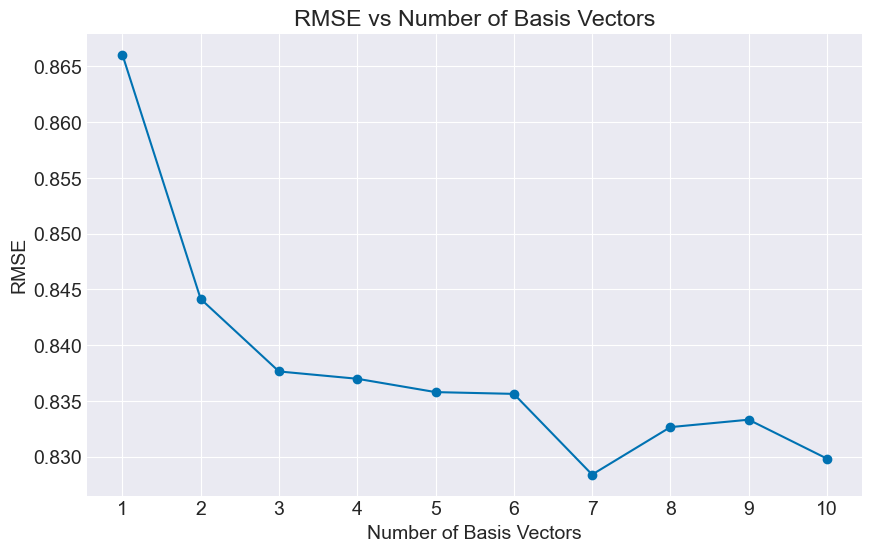

In [34]:
num_basis_vectors_list = [1,2,3,4,5,6,7,8,9,10]
rmse_values = []

for num_bvs in num_basis_vectors_list:
    svd_model = FunkSVD(num_bvs)
    svd_model.fit(A_fit)
    val_preds = svd_model.predict()
    val_preds_extracted = val_preds[val_indices_df['row_inds'], val_indices_df['col_inds']]
    rmse_val = svd_model.rmse(val_ratings, val_preds_extracted)
    rmse_values.append(rmse_val)

plt.figure(figsize=(10, 6))
plt.plot(num_basis_vectors_list, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs Number of Basis Vectors')
plt.xlabel('Number of Basis Vectors')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(num_basis_vectors_list)
plt.show()

Looks like there's a large dip in RMSE at 7 basis vectors just like with regular SVD, weird coincidence. Let's see if we can optimize this further...

### 2. Testing Step Count

Hypothetically, the smaller the better, so let's see how much...

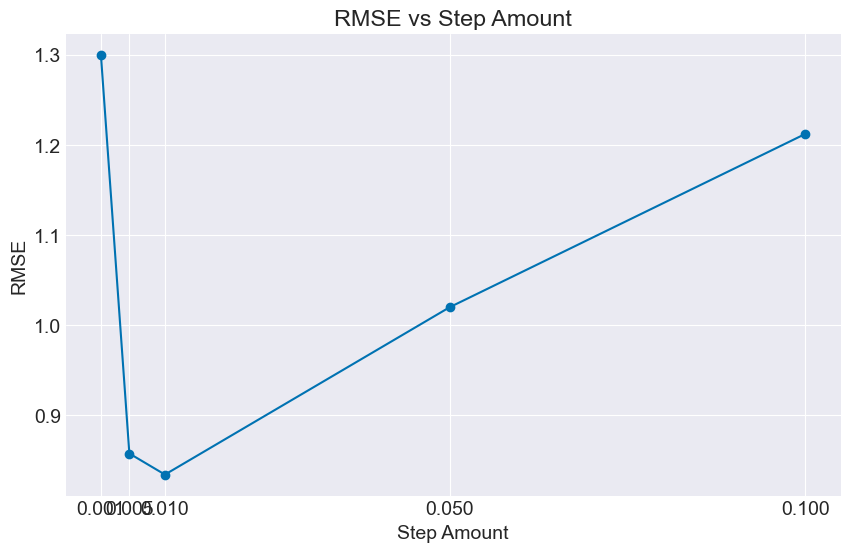

In [35]:
num_step = [0.001,0.005,0.01,0.05,0.1]
rmse_values = []

for stepnum in num_step:
    svd_model = FunkSVD(9)
    svd_model.fit(A_fit, step=stepnum)
    val_preds = svd_model.predict()
    val_preds_extracted = val_preds[val_indices_df['row_inds'], val_indices_df['col_inds']]
    rmse_val = svd_model.rmse(val_ratings, val_preds_extracted)
    rmse_values.append(rmse_val)

plt.figure(figsize=(10, 6))
plt.plot(num_step, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs Step Amount')
plt.xlabel('Step Amount')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(num_step)
plt.show()

Small but significant reducation at 0.01, but its good to be careful. There's also a  very large RMSE bump near 0.001, which could be due to the fact that we're taking too little steps within the iteration amounts to actually get there, but doing more iterations sacrifices a lot of time...

### 3. Testing Iteration Count

In theory, the more the better, but we know that the more iterations the more runtime this will take, but in the name of science, we shall wait.

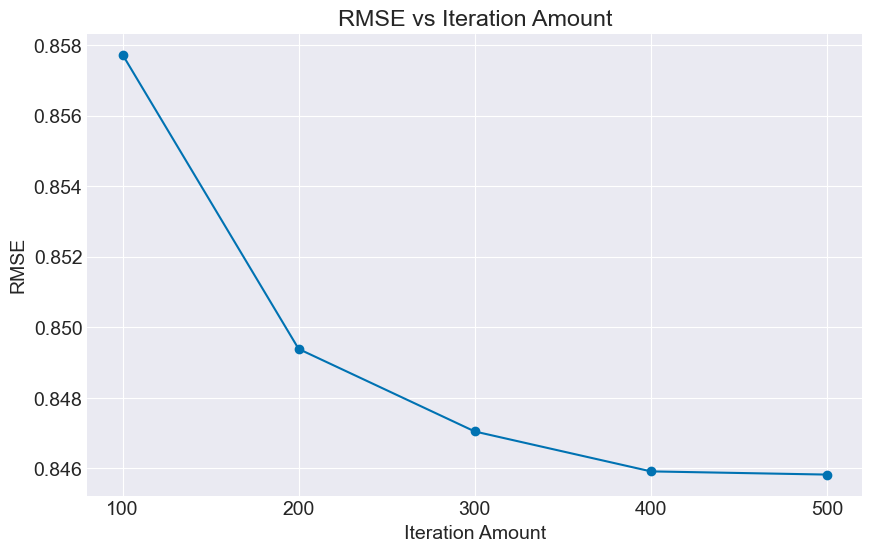

In [36]:
num_iter = [100,200,300,400,500]
rmse_values = []

for iter in num_iter:
    svd_model = FunkSVD(9)
    svd_model.fit(A_fit, n_iter=iter,step = 0.005)
    val_preds = svd_model.predict()
    val_preds_extracted = val_preds[val_indices_df['row_inds'], val_indices_df['col_inds']]
    rmse_val = svd_model.rmse(val_ratings, val_preds_extracted)
    rmse_values.append(rmse_val)

plt.figure(figsize=(10, 6))
plt.plot(num_iter, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs Iteration Amount')
plt.xlabel('Iteration Amount')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(num_iter)
plt.show()

Looks like the hypothesis was confirmed: more iterations seem to make the largest difference in reducing the RMSE, although it leads to stagnation...

### 4. Testing Regularization Count

Supposedly there's a sweet spot towards finding the best regularization, so let's try to find that as well.

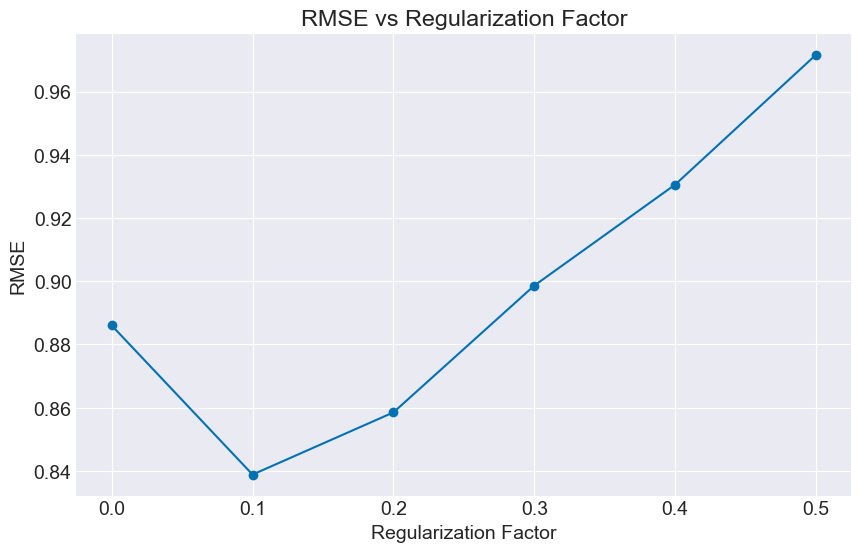

In [47]:
num_reg = [0,0.1,0.2,0.3,0.4,0.5]
rmse_values = []

for regg in num_reg:
    svd_model = FunkSVD(4)
    svd_model.fit(A_fit, reg =regg)
    val_preds = svd_model.predict()
    val_preds_extracted = val_preds[val_indices_df['row_inds'], val_indices_df['col_inds']]
    rmse_val = svd_model.rmse(val_ratings, val_preds_extracted)
    rmse_values.append(rmse_val)

plt.figure(figsize=(10, 6))
plt.plot(num_reg, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs Regularization Factor')
plt.xlabel('Regularization Factor')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(num_reg)
plt.show()

Hmm, perhaps the regularization default was enough.

<b> Full disclosure, you may notice that the RMSE didn't actually get any lower for some of the graphs. That's because FunkSVD has so many variables that play into its error, that it would take forever to examine them all. Believe me, this already took me 2 hours to run. Factors like regularization and step count do influence each other, and to fully find the aspect of them that reduce the runtime the most would require me to make some type of Heatmap or 3D graph. But that would require me to run (# tester regularization counts x # step amounts) which, already takes a whole lot of time to run in itself. Unfortunately, I do not have that kind of time on my hands. Generally though, we can come to the conclusion that the more runtime, the more accurate, but it seems like its by not that much, which is alright, because having a mean squared error less than 1 is already pretty good! <b>

## KUDOS

As always, Layton helped troubleshoot my code since I was being very stupid with bugs.